*******
# Introduction

For the final project, I will predict the income of individuals based on a variety of factors. That is, I will predict whether the income is above $33,132 (approximate real median income, base year of 2016 with units of 2019 CPI-U-RS Adjusted Dollars) using a binary classifier. The income is predicted using variables that could affect the income such as education level, age, etc. This is important because being able to predict income can enable economists and policy makers to allocate resources to specific groups of people, regions, etc. Ultimately, this would enable policy makers to make decisions that would improve income and the quality of life. There are a variety of ways to do so and a few examples include investing in education and giving incentives for companies to open new locations in underprivileged communities.

Note: I am slightly changing what I am predicting becasue I felt that prediciting income using a binary classifier would be more interesting. Therefore, I am changing this to a classification problem. Also, I have removed/added some variables because some of them had a lot of data missing and was not well organized once I tried to warngle and clean it. I had to download a new dataset.

*******
# Data Wrangling and Cleaning

**Data was retrieved exclusively from IPUMS USA.**

I am first going to import some packages I might need, load the data as `dfdata`, and create an `id` variable using `serial` and `pernum` as done in homework 1.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc = {'axes.titlesize': 28,
             'axes.labelsize': 26,
             'xtick.labelsize': 16,
             'ytick.labelsize': 16,
             'figure.figsize': (12, 8)})

dfdata = pd.read_csv('C:/Users/Marko/Documents/ECON 490 AML Data/income.csv')
dfdata.columns = dfdata.columns.str.lower()
dfdata['id'] = dfdata.serial*100 + dfdata.pernum
dfdata.dropna(inplace = True)
dfdata.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048575 entries, 0 to 1048574
Data columns (total 19 columns):
 #   Column    Non-Null Count    Dtype
---  ------    --------------    -----
 0   serial    1048575 non-null  int64
 1   gq        1048575 non-null  int64
 2   pernum    1048575 non-null  int64
 3   perwt     1048575 non-null  int64
 4   nchild    1048575 non-null  int64
 5   sex       1048575 non-null  int64
 6   age       1048575 non-null  int64
 7   marst     1048575 non-null  int64
 8   race      1048575 non-null  int64
 9   raced     1048575 non-null  int64
 10  hispan    1048575 non-null  int64
 11  hispand   1048575 non-null  int64
 12  educ      1048575 non-null  int64
 13  educd     1048575 non-null  int64
 14  occ2010   1048575 non-null  int64
 15  ind1990   1048575 non-null  int64
 16  uhrswork  1048575 non-null  int64
 17  incwage   1048575 non-null  int64
 18  id        1048575 non-null  int64
dtypes: int64(19)
memory usage: 160.0 MB


The data set needs to be filtered and the best way to do it is by replicating what was done in homework 1. There wuold be no group quarters, onyl ages 16 to 65, no military that are unemployed, remove all values of N/A in EDUCD, military, or that have worked last in 1984.
Filter the data set such that:

In [2]:
dfdata = dfdata.loc[dfdata['gq'].isin([1,2]) & 
             (dfdata['age'] >= 16) & (dfdata['age'] <65) &
             ~dfdata['occ2010'].isin([9800, 9810, 9820, 9830, 9920]) &
             (dfdata['ind1990'] != 0) & (dfdata['ind1990'] < 940) &
             (dfdata.educd != 0)].copy()

1. Then, to create a variable as done in the homework which would determined the years of schooling using mapping.
2. Also, to create dummy variables for `sex`, `children`, `race`, and `hispanic`. 

In [3]:
#1
school = {2:0, 11:0, 12:0,
                  14:1, 15:2, 16:3, 17:4, 22:5, 23:6, 25:7, 26:8, 30:9, 40:10, 50:11,
                  61:12, 63:12, 64:12, 65:12,
                  71:13, 81:12, 101:16, 114:18, 115:20, 116:20}
dfdata['years'] = dfdata.educd.map(school)
dfdata['experience'] = dfdata.age - dfdata.years - 6

#2
dfdata['female'] = (dfdata['sex'] == 2)*1
dfdata['any_kids'] = (dfdata['nchild'] >= 1)*1
dfdata['black'] = (dfdata['race'] == 2)*1
dfdata['hispanic'] = (dfdata['hispan'] > 1)*1

We will create a `degree` variable just like in homework 1 and then create 3 dummy variables. Then, drop `degree`.

In [4]:
dfdata['degree'] = np.where(dfdata.educd < 65, 'hs or less', 
                         np.where(dfdata.educd < 101, 'some college', 'ba or more'))
dfdata['some_college'] = (dfdata['degree'] == "some college") * 1
dfdata['hs_or_less'] = (dfdata['degree'] == "hs or less") * 1
dfdata['ba_or_more'] = (dfdata['degree'] == "ba or more") * 1
dfdata.drop(columns = ['degree'], inplace = True)

I have to group some features. For now, the best to group are percentage with bachelor's degree and group by occupation, average wage grouped by industry (as done in homework 1), and marital status grouped by age. The grouping with age and marital status was created because there is typically a certain grouping that can be created between age and marital status.

In [5]:
oc = pd.DataFrame()
oc['occ_ba'] = dfdata.groupby('occ2010').apply(lambda x: 100*sum((x.educd >= 101)*x.perwt)/sum(x.perwt))
dfdata = dfdata.join(oc, on = 'occ2010')

wage = pd.DataFrame()
wage['in_wage'] = dfdata.groupby('ind1990').apply(lambda x: sum(x.incwage*x.perwt)/sum(x.perwt))
dfdata = dfdata.join(wage, on = 'ind1990')

stat = pd.DataFrame()
stat['age_mar'] = dfdata.groupby('marst').apply(lambda x: sum(x.age*x.perwt)/sum(x.perwt))
dfdata = dfdata.join(stat, on = 'marst')

Next, I will reorganize the data set by trimming it and setting the index to `id` with `occ2010` and `ind1990` as well since they are not needed in analysis. Drop all values of `in_wage` that are zero. From there, I will add a column which would indicate whether or not the `incwage` is above $50,000 (equal to 1) or below. I will keep the `in_wage` values just in case I might need it, however, it will not be used in analysis as far I have planned.

In [6]:
print(dfdata.columns)
dfdata = dfdata[dfdata.in_wage > 0].copy()
dfdata['bin_wage'] = (dfdata['in_wage'] > 33132)*1
dfdata = dfdata[['id', 'in_wage', 'bin_wage', 'occ2010', 'ind1990', 'uhrswork','experience', 'female', 'any_kids', 'black', 'hispanic', 'some_college', 'hs_or_less',
       'ba_or_more', 'occ_ba', 'age_mar', 'marst']]
dfdata.set_index(['id','occ2010', 'ind1990'], inplace = True)


Index(['serial', 'gq', 'pernum', 'perwt', 'nchild', 'sex', 'age', 'marst',
       'race', 'raced', 'hispan', 'hispand', 'educ', 'educd', 'occ2010',
       'ind1990', 'uhrswork', 'incwage', 'id', 'years', 'experience', 'female',
       'any_kids', 'black', 'hispanic', 'some_college', 'hs_or_less',
       'ba_or_more', 'occ_ba', 'in_wage', 'age_mar'],
      dtype='object')


In [7]:
dfdata.head()

,,,in_wage,bin_wage,uhrswork,experience,female,any_kids,black,hispanic,some_college,hs_or_less,ba_or_more,occ_ba,age_mar,marst
id,occ2010,ind1990,,,,,,,,,,,,,,
301,5310,831,50931.330473,1,40,45,1,0,0,0,1,0,0,17.136427,44.313648,1
401,4000,832,25662.936154,0,32,43,1,1,1,0,0,1,0,4.784706,46.979363,4
402,5350,662,13649.986856,0,40,20,0,0,1,0,0,1,0,12.652608,29.822957,6
701,5620,600,19494.316705,0,20,8,1,0,0,0,0,1,0,6.125904,29.822957,6
801,5940,741,30958.943667,0,35,23,1,1,0,0,1,0,0,29.568023,44.313648,1


In [8]:
dfdata.shape

(546804, 14)

In [9]:
dfdata.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 546804 entries, (301, 5310, 831) to (46867202, 4230, 761)
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   in_wage       546804 non-null  float64
 1   bin_wage      546804 non-null  int32  
 2   uhrswork      546804 non-null  int64  
 3   experience    546804 non-null  int64  
 4   female        546804 non-null  int32  
 5   any_kids      546804 non-null  int32  
 6   black         546804 non-null  int32  
 7   hispanic      546804 non-null  int32  
 8   some_college  546804 non-null  int32  
 9   hs_or_less    546804 non-null  int32  
 10  ba_or_more    546804 non-null  int32  
 11  occ_ba        546804 non-null  float64
 12  age_mar       546804 non-null  float64
 13  marst         546804 non-null  int64  
dtypes: float64(3), int32(8), int64(3)
memory usage: 70.1 MB


In [10]:
dfdata.describe()

,in_wage,bin_wage,uhrswork,experience,female,any_kids,black,hispanic,some_college,hs_or_less,ba_or_more,occ_ba,age_mar,marst
count,546804.000000,546804.000000,546804.000000,546804.000000,546804.000000,546804.000000,546804.000000,546804.000000,546804.000000,546804.000000,546804.000000,546804.000000,546804.000000,546804.000000
mean,36298.078235,0.540578,34.792745,21.892108,0.497143,0.448810,0.095350,0.062585,0.331664,0.353907,0.314429,30.736908,40.448892,2.891680
std,16310.228012,0.498351,16.301046,13.185097,0.499992,0.497373,0.293699,0.242216,0.470811,0.478181,0.464288,28.647852,6.919441,2.225965
min,6309.451684,0.000000,0.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.822957,1.000000
25%,24020.103049,0.000000,30.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.314625,29.822957,1.000000
50%,34388.867078,1.000000,40.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.783197,44.313648,1.000000
75%,47986.502842,1.000000,40.000000,33.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,51.845703,44.313648,6.000000
max,90992.372302,1.000000,99.000000,58.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000,53.152282,6.000000


In [11]:
dfdata.to_pickle("final_income.pkl")

*******
# Label Figure

<AxesSubplot:title={'center':'Binary Wage Income Distribution'}, xlabel='Wage Income Above $33,132', ylabel='Count'>

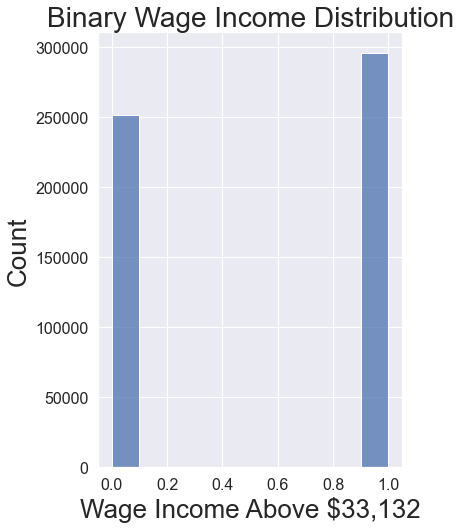

In [12]:
plt.figure()
plt.subplot(1,2,1)
plt.title('Binary Wage Income Distribution')
plt.xlabel('Wage Income Above $33,132')
sns.histplot(x = 'bin_wage', data = dfdata, bins = 10)


Although it would be nice and good to have a great accuracy, I would care more about the sensitivity. This is because I want the model to have more "power" by correctly prediciting whether an individuals income is greater than $33,132 or not.

*******
# Feature Transformations

Drop all values of zero that occur in `occ_ba` and `age_mar`.

In [13]:
dfdata = dfdata[dfdata.occ_ba > 0].copy()
dfdata = dfdata[dfdata.age_mar > 0].copy()

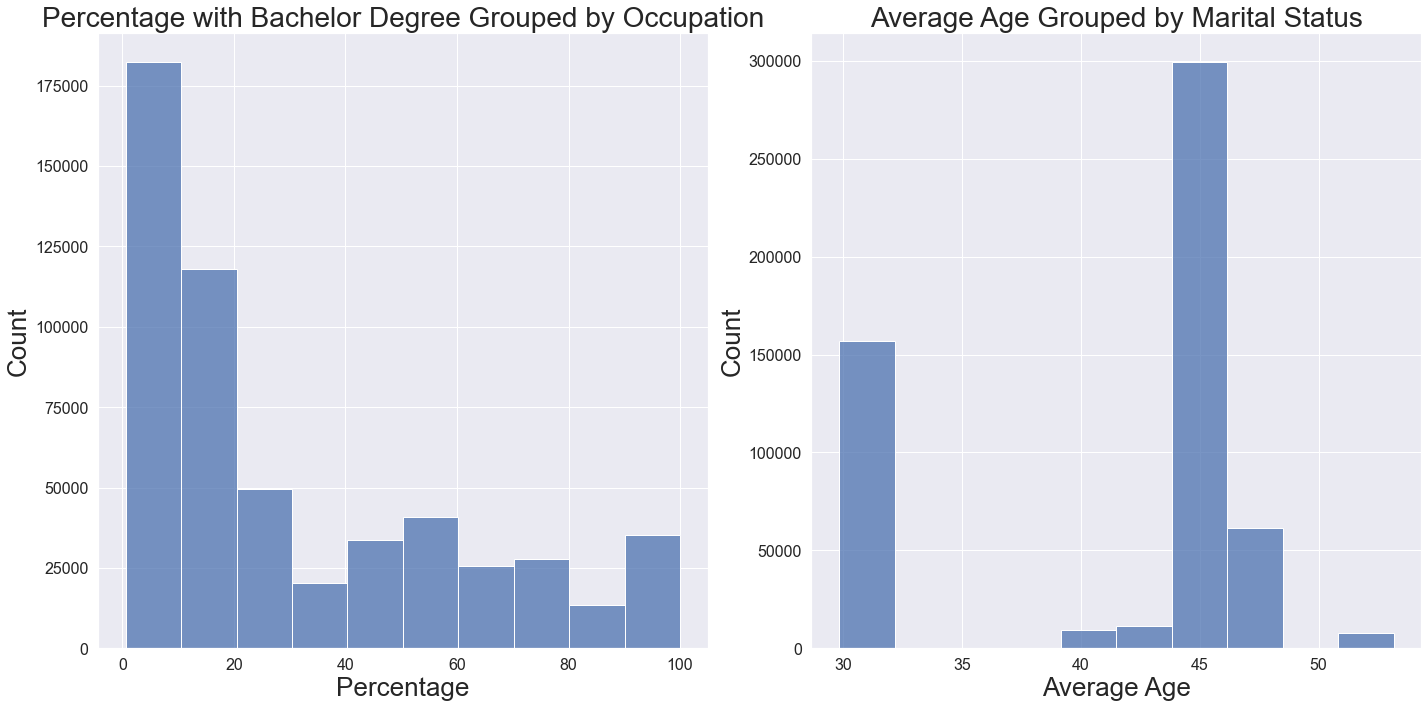

In [14]:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.title('Percentage with Bachelor Degree Grouped by Occupation')
plt.xlabel('Percentage')
sns.histplot(x = 'occ_ba', data = dfdata, bins = 10)

plt.subplot(1,2,2)
plt.title('Average Age Grouped by Marital Status')
plt.xlabel('Average Age')
sns.histplot(x = 'age_mar', data = dfdata, bins = 10)

plt.tight_layout()

No need to transform these variable because one is percentage and the other can not be transformed. The `age_mar` can not be transformed because there is not clear direction as to what transformation should be done and all the transformations I tried did not work. Also, it doesn't make sense to transform them either way.

*******
# Feature vs Label Plots

1. Figure 1

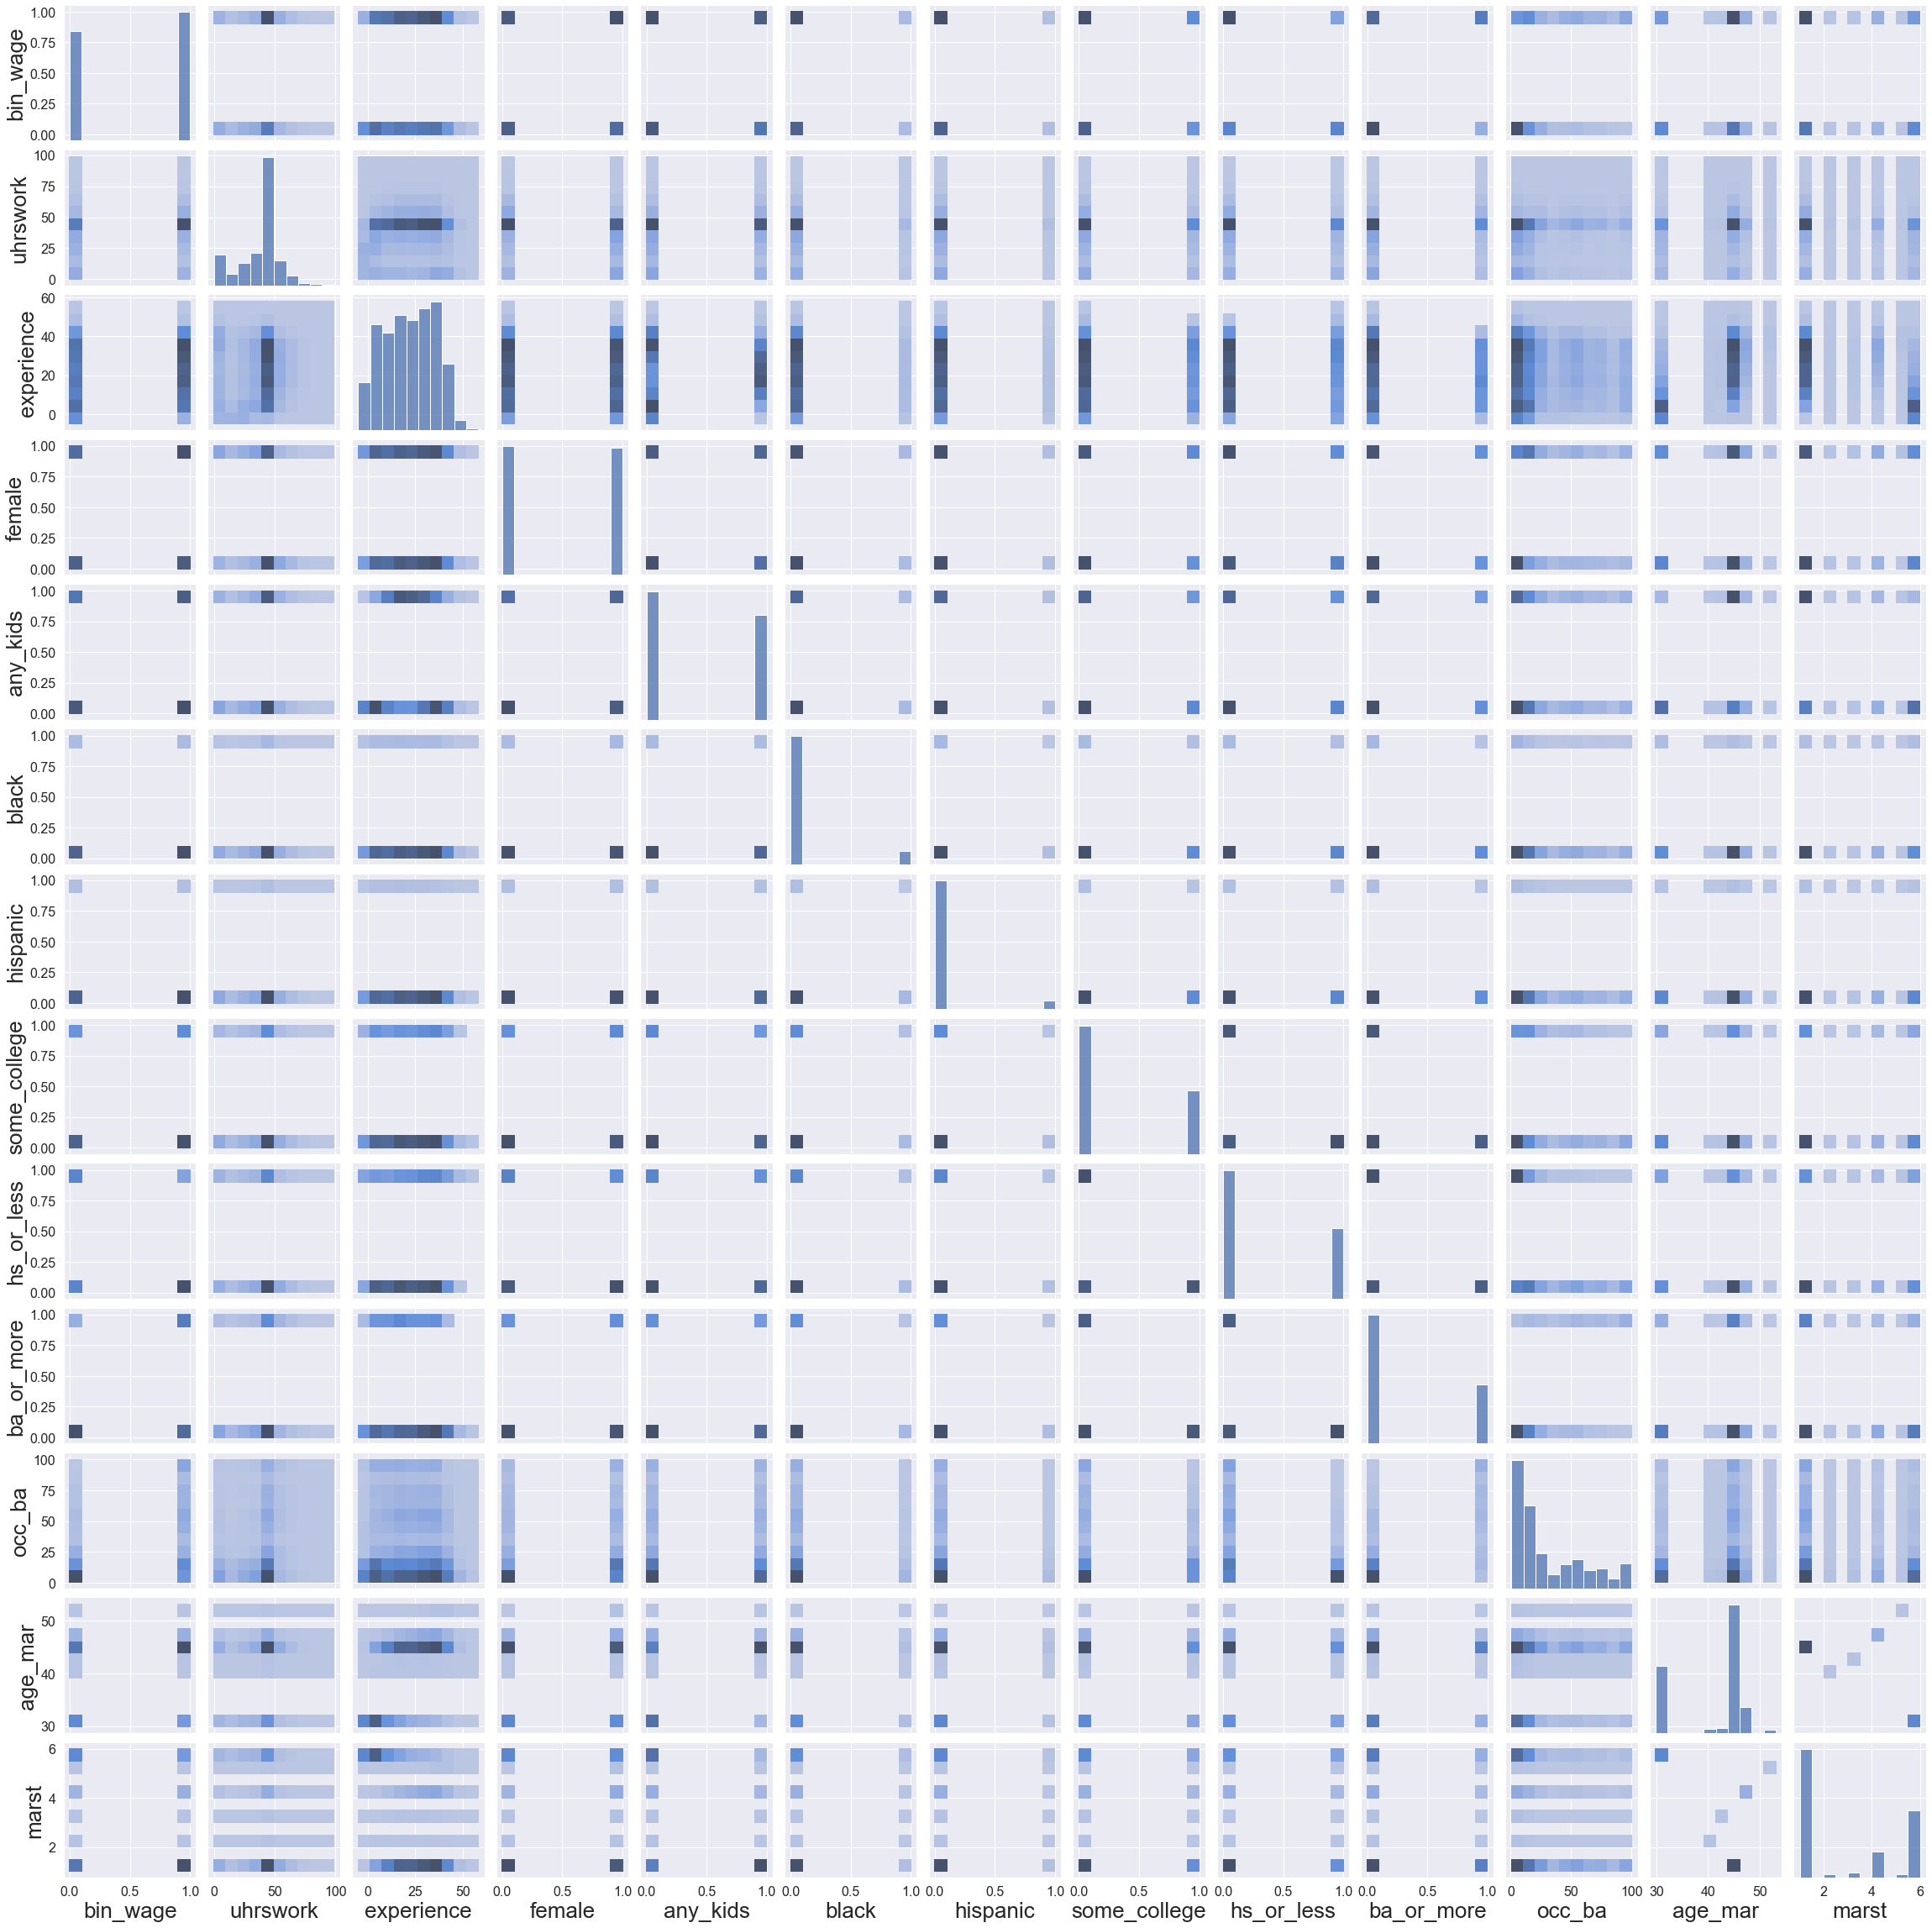

In [15]:
temp2 = dfdata
temp2.drop(columns = ['in_wage'], inplace = True)
sns.pairplot(data = temp2, kind = 'hist', plot_kws = {'bins': 10}, diag_kws = {'bins': 10})
plt.show()

The variable that has a logarithmic relationship with `bin_wage` is `occ_ba`. There appears to be a slight linear realationship between `bin_wage` and `experience`, as well as `bin_wage` and `uhrswork`, however, it does not look like a strong normal distribution. All the other variables do not have a clear relationship with `bin_wage` nor are there relationships between the features.

2. Figure 2 (Discrete vs Discrete Variables & Continuous vs Discrete Variables)

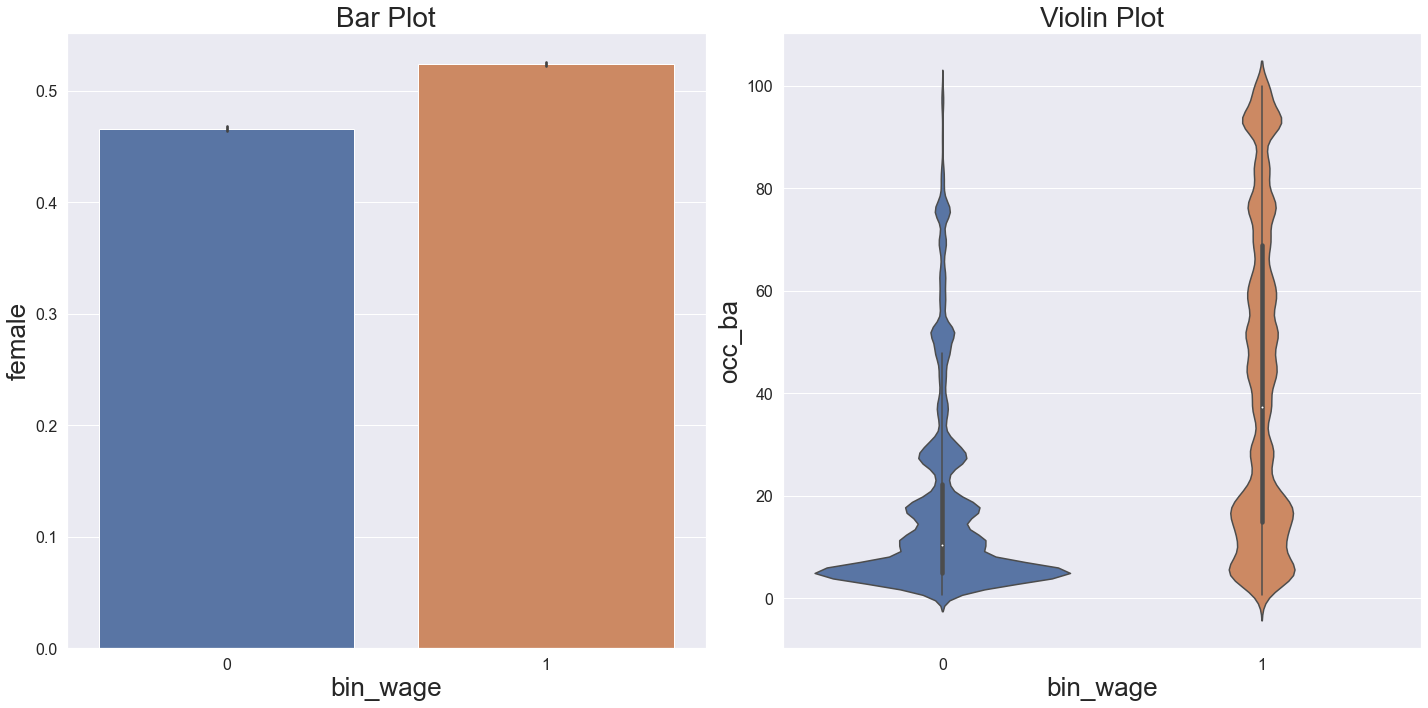

In [16]:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.title("Bar Plot")
sns.barplot(data = dfdata, x = 'bin_wage', y = 'female')

plt.subplot(1,2,2)
plt.title("Violin Plot")
sns.violinplot(data = dfdata, x = 'bin_wage', y = 'occ_ba')

plt.tight_layout()

The bar plot goes up to a value a little less than 0.55, by obeservation. The violin plot for `occ` when `bin_wage` equal to 0 has a distribution that is skewed to the right. The mean and interquartile range between a `bin_wage` of 0 and 1 are very different.